# Automated Machine Learning
_**Classification of credit card fraudulent transactions with local run **_

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Train](#Train)
1. [Results](#Results)
1. [Test](#Tests)
1. [Explanation](#Explanation)
1. [Acknowledgements](#Acknowledgements)

## Introduction

In this example we use the associated credit card dataset to showcase how you can use AutoML for a simple classification problem. The goal is to predict if a credit card transaction is considered a fraudulent charge.

This notebook is using the local machine compute to train the model.

If you are using an Azure Machine Learning Compute Instance, you are all set. Otherwise, go through the [configuration](../../../configuration.ipynb) notebook first if you haven't already to establish your connection to the AzureML Workspace. 

In this notebook you will learn how to:
1. Create an experiment using an existing workspace.
2. Configure AutoML using `AutoMLConfig`.
3. Train the model.
4. Explore the results.
5. Test the fitted model.
6. Explore any model's explanation and explore feature importance in azure portal.
7. Create an AKS cluster, deploy the webservice of AutoML scoring model and the explainer model to the AKS and consume the web service.

## Setup

As part of the setup you have already created an Azure ML `Workspace` object. For Automated ML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [1]:
import logging

from matplotlib import pyplot as plt
import pandas as pd

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig
from azureml.interpret import ExplanationClient

This sample notebook may use features that are not available in previous versions of the Azure ML SDK.

In [2]:
ws = Workspace.from_config()

# choose a name for experiment
experiment_name = "automl-classification-ccard-local"

experiment = Experiment(ws, experiment_name)

output = {}
output["Subscription ID"] = ws.subscription_id
output["Workspace"] = ws.name
output["Resource Group"] = ws.resource_group
output["Location"] = ws.location
output["Experiment Name"] = experiment.name
pd.set_option("display.max_colwidth", -1)
outputDf = pd.DataFrame(data=output, index=[""])
outputDf.T

,
Subscription ID,d83b98a9-eaa6-475f-9ae6-1ef35394a1e5
Workspace,shepml
Resource Group,rg-ml-workspace
Location,eastus2
Experiment Name,automl-classification-ccard-local


### Load Data

Load the credit card dataset from a csv file containing both training features and labels. The features are inputs to the model, while the training labels represent the expected output of the model. Next, we'll split the data using random_split and extract the training data for the model.

In [3]:
data = "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/creditcard.csv"
dataset = Dataset.Tabular.from_delimited_files(data)
training_data, validation_data = dataset.random_split(percentage=0.8, seed=223)
label_column_name = "Class"

## Train

Instantiate a AutoMLConfig object. This defines the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification or regression|
|**primary_metric**|This is the metric that you want to optimize. Classification supports the following primary metrics: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>average_precision_score_weighted</i><br><i>norm_macro_recall</i><br><i>precision_score_weighted</i>|
|**enable_early_stopping**|Stop the run if the metric score is not showing improvement.|
|**n_cross_validations**|Number of cross validation splits.|
|**training_data**|Input dataset, containing both features and label column.|
|**label_column_name**|The name of the label column.|

**_You can find more information about primary metrics_** [here](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train#primary-metric)

In [4]:
data = "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/creditcard.csv"
dataset = Dataset.Tabular.from_delimited_files(data)
training_data, validation_data = dataset.random_split(percentage=0.7)
label_column_name = "Class"

automl_settings = {
    "n_cross_validations": 3, #Number of cross validation splits.
    "primary_metric": "average_precision_score_weighted", #This is the metric that you want to optimize.
    "experiment_timeout_hours": 0.25, #percentage of an hour you want this to run
    "verbosity": logging.INFO, #logging info level, debug, info, warning, error, critical 
    "enable_stack_ensemble": False, # VotingEnsembled is enabled by defualt
}

automl_config = AutoMLConfig(
    task="classification",
    debug_log="automl_errors.log",
    training_data=training_data,
    label_column_name=label_column_name,
    **automl_settings,
)

local_run = experiment.submit(automl_config, show_output=True)

No run_configuration provided, running on local with default configuration


2022-10-27:14:24:13,411 INFO     [modeling_bert.py:226] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
2022-10-27:14:24:13,426 INFO     [modeling_xlnet.py:339] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
2022-10-27:14:24:19,770 INFO     [utils.py:159] NumExpr defaulting to 4 threads.


Running in the active local environment.


Experiment,Id,Type,Status,Details Page,Docs Page
automl-classification-ccard-local,AutoML_a3ac3461-6038-4e17-a5a6-f06de5ef6f00,automl,Preparing,Link to Azure Machine Learning studio,Link to Documentation


Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.
Current status: DatasetBalancing. Performing class balancing sweeping
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

********************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       ALERTED
DESCRIPTION:  To decrease model bias, please cancel the current run and fix balancing problem.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData
DETAILS:      Imbalanced data can lead to a falsely perceived positive effect of a model's accuracy because the input data has bias towards one cl

2022-10-27:14:42:56,730 INFO     [explanation_client.py:334] Using default datastore for uploads


Current status: EngineeredFeatureExplanations. Computation of engineered features completed
Current status: RawFeaturesExplanations. Computation of raw features started
Current status: RawFeaturesExplanations. Computation of raw features completed
Current status: BestRunExplainModel. Best run model explanations completed
********************************************************************************************


Call the `submit` method on the experiment object and pass the run configuration. Depending on the data and the number of iterations this can run for a while.
In this example, we specify `show_output = True` to print currently running iterations to the console.

In [5]:
#local_run = experiment.submit(automl_config, show_output=True)

In [6]:
# If you need to retrieve a run that already started, use the following code
# from azureml.train.automl.run import AutoMLRun
# local_run = AutoMLRun(experiment = experiment, run_id = '<replace with your run id>')

## Results

#### Widget for Monitoring Runs

The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

**Note:** The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details

In [7]:
from azureml.widgets import RunDetails

RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

### Analyze results

#### Retrieve the Best Model

Below we select the best pipeline from our iterations. The `get_output` method on `automl_classifier` returns the best run and the fitted model for the last invocation. Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

In [8]:
best_run, fitted_model = local_run.get_output()
fitted_model

PipelineWithYTransformations(Pipeline={'memory': None,
                                       'steps': [('datatransformer',
                                                  DataTransformer(enable_dnn=False, enable_feature_sweeping=True, feature_sweeping_config={}, feature_sweeping_timeout=86400, featurization_config=None, force_text_dnn=False, is_cross_validation=True, is_onnx_compatible=False, observer=None, task='classification', working_dir='/mn...
    gpu_training_param_dict={'processing_unit_type': 'cpu'}
), random_state=0, reg_alpha=1.875, reg_lambda=0.9375, subsample=0.5, tree_method='auto'))], verbose=False))], flatten_transform=None, weights=[0.4666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.2, 0.06666666666666667]))],
                                       'verbose': False},
                             y_transformer={},
                             y_transformer_name='LabelEncoder')

#### Print the properties of the model
The fitted_model is a python object and you can read the different properties of the object.


## Tests

Now that the model is trained, split the data in the same way the data was split for training (The difference here is the data is being split locally) and then run the test data through the trained model to get the predicted values.

In [9]:
# convert the test data to dataframe
X_test_df = validation_data.drop_columns(columns=[label_column_name]).to_pandas_dataframe()

y_test_df = validation_data.keep_columns(columns=[label_column_name], validate=True).to_pandas_dataframe()

In [10]:
# call the predict functions on the model
y_pred = fitted_model.predict(X_test_df)
y_pred

array([False, False, False, ..., False, False, False])

### Calculate metrics for the prediction

Now visualize the data on a scatter plot to show what our truth (actual) values are compared to the predicted values 
from the trained model that was returned.

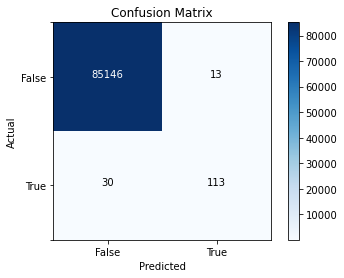

In [11]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

cf = confusion_matrix(y_test_df.values, y_pred)
plt.imshow(cf, cmap=plt.cm.Blues, interpolation="nearest")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
class_labels = ["False", "True"]
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks([-0.5, 0, 1, 1.5], ["", "False", "True", ""])
# plotting text value inside cells
thresh = cf.max() / 2.0
for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
    plt.text(
        j,
        i,
        format(cf[i, j], "d"),
        horizontalalignment="center",
        color="white" if cf[i, j] > thresh else "black",
    )
plt.show()

## Explanation
In this section, we will show how to compute model explanations and visualize the explanations using azureml-interpret package. We will also show how to run the automl model and the explainer model through deploying an AKS web service.

Besides retrieving an existing model explanation for an AutoML model, you can also explain your AutoML model with different test data. The following steps will allow you to compute and visualize engineered feature importance based on your test data.

### Run the explanation
#### Download the engineered feature importance from artifact store
You can use ExplanationClient to download the engineered feature explanations from the artifact store of the best_run. You can also use azure portal url to view the dash board visualization of the feature importance values of the engineered features.

In [12]:
client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=False)
print(engineered_explanations.get_feature_importance_dict())
print(
    "You can visualize the engineered explanations under the 'Explanations (preview)' tab in the AutoML run at:-\n"
    + best_run.get_portal_url()
)

2022-10-27:14:43:23,782 INFO     [explanation_client.py:334] Using default datastore for uploads


{'V4_MeanImputer': 0.0673188368222275, 'V14_MeanImputer': 0.03586319006011275, 'V17_MeanImputer': 0.028072865066621454, 'V8_MeanImputer': 0.019549133063068727, 'V12_MeanImputer': 0.016035753323253153, 'V13_MeanImputer': 0.015565214606867776, 'V22_MeanImputer': 0.0149421116316385, 'V11_MeanImputer': 0.013829874644517098, 'Time_MeanImputer': 0.012446055694371056, 'V7_MeanImputer': 0.010750257862506307, 'V18_MeanImputer': 0.008978232502008474, 'V10_MeanImputer': 0.007299233239741598, 'V5_MeanImputer': 0.0063120310124227695, 'Amount_MeanImputer': 0.006241303015688428, 'V19_MeanImputer': 0.005942608000477762, 'V26_MeanImputer': 0.005327480991105602, 'V1_MeanImputer': 0.005255373715354525, 'V28_MeanImputer': 0.004953200955075525, 'V2_MeanImputer': 0.004124763897936349, 'V16_MeanImputer': 0.004029335263499985, 'V25_MeanImputer': 0.0038285371847652833, 'V24_MeanImputer': 0.0025587610210930853, 'V21_MeanImputer': 0.0023784854241159026, 'V15_MeanImputer': 0.001654782603682882, 'V6_MeanImputer': 

#### Download the raw feature importance from artifact store
You can use ExplanationClient to download the raw feature explanations from the artifact store of the best_run. You can also use azure portal url to view the dash board visualization of the feature importance values of the raw features.

In [13]:
raw_explanations = client.download_model_explanation(raw=True)
print(raw_explanations.get_feature_importance_dict())
print(
    "You can visualize the raw explanations under the 'Explanations (preview)' tab in the AutoML run at:-\n"
    + best_run.get_portal_url()
)

{'V4': 0.0673188368222275, 'V14': 0.03586319006011275, 'V17': 0.028072865066621454, 'V8': 0.019549133063068727, 'V12': 0.016035753323253153, 'V13': 0.015565214606867776, 'V22': 0.0149421116316385, 'V11': 0.013829874644517098, 'Time': 0.012446055694371056, 'V7': 0.010750257862506307, 'V18': 0.008978232502008474, 'V10': 0.007299233239741598, 'V5': 0.0063120310124227695, 'Amount': 0.006241303015688428, 'V19': 0.005942608000477762, 'V26': 0.005327480991105602, 'V1': 0.005255373715354525, 'V28': 0.004953200955075525, 'V2': 0.004124763897936349, 'V16': 0.004029335263499985, 'V25': 0.0038285371847652833, 'V24': 0.0025587610210930853, 'V21': 0.0023784854241159026, 'V15': 0.001654782603682882, 'V6': 0.0016333833299713926, 'V3': 0.001601331518337637, 'V9': 0.0009529664639982349, 'V23': 0.0009017160052017162, 'V27': 0.0005506715846266405, 'V20': 0.0004379849489903072}
You can visualize the raw explanations under the 'Explanations (preview)' tab in the AutoML run at:-
https://ml.azure.com/runs/Aut

#### Retrieve any other AutoML model from training

In [14]:
automl_run, fitted_model = local_run.get_output(metric="accuracy")

#### Setup the model explanations for AutoML models
The fitted_model can generate the following which will be used for getting the engineered explanations using automl_setup_model_explanations:-

1. Featurized data from train samples/test samples
2. Gather engineered name lists
3. Find the classes in your labeled column in classification scenarios

The automl_explainer_setup_obj contains all the structures from above list.

In [15]:
X_train = training_data.drop_columns(columns=[label_column_name])
y_train = training_data.keep_columns(columns=[label_column_name], validate=True)
X_test = validation_data.drop_columns(columns=[label_column_name])

In [16]:
from azureml.train.automl.runtime.automl_explain_utilities import (
    automl_setup_model_explanations,
)

automl_explainer_setup_obj = automl_setup_model_explanations(
    fitted_model,
    X=X_train,
    X_test=X_test,
    y=y_train,
    task="classification",
    automl_run=automl_run,
)

Current status: Setting up data for AutoML explanations
Current status: Setting up the AutoML featurizer
Current status: Setting up the AutoML estimator
Current status: Setting up the AutoML featurization for explanations
Current status: Downsampling of evaluation samples from 85302 to 5000 samples
Current status: Generating a feature map for raw feature importance
Current status: Finding all classes from the dataset
Current status: Choosing the surrogate model as LightGBM for the AutoML model
Current status: Data for AutoML explanations successfully setup


#### Initialize the Mimic Explainer for feature importance
For explaining the AutoML models, use the MimicWrapper from azureml-interpret package. The MimicWrapper can be initialized with fields in automl_explainer_setup_obj, your workspace and a surrogate model to explain the AutoML model (fitted_model here). The MimicWrapper also takes the automl_run object where engineered explanations will be uploaded.

In [17]:
from azureml.interpret.mimic_wrapper import MimicWrapper

explainer = MimicWrapper(
    ws,
    automl_explainer_setup_obj.automl_estimator,
    explainable_model=automl_explainer_setup_obj.surrogate_model,
    init_dataset=automl_explainer_setup_obj.X_transform,
    run=automl_explainer_setup_obj.automl_run,
    features=automl_explainer_setup_obj.engineered_feature_names,
    feature_maps=[automl_explainer_setup_obj.feature_map],
    classes=automl_explainer_setup_obj.classes,
    explainer_kwargs=automl_explainer_setup_obj.surrogate_model_params,
)

#### Use Mimic Explainer for computing and visualizing engineered feature importance
The explain() method in MimicWrapper can be called with the transformed test samples to get the feature importance for the generated engineered features. You can also use azure portal url to view the dash board visualization of the feature importance values of the engineered features.

In [18]:
# Compute the engineered explanations
engineered_explanations = explainer.explain(
    ["local", "global"], eval_dataset=automl_explainer_setup_obj.X_test_transform
)
print(engineered_explanations.get_feature_importance_dict())
print(
    "You can visualize the engineered explanations under the 'Explanations (preview)' tab in the AutoML run at:-\n"
    + automl_run.get_portal_url()
)

2022-10-27:14:44:32,587 INFO     [explanation_client.py:334] Using default datastore for uploads


{'V14_MeanImputer': 0.024853115043223403, 'V10_MeanImputer': 0.006494493464911045, 'V12_MeanImputer': 0.005668941712183879, 'V17_MeanImputer': 0.005122254205512521, 'V4_MeanImputer': 0.003802679161834286, 'V7_MeanImputer': 0.003239871900682652, 'V16_MeanImputer': 0.0014242052277191784, 'V20_MeanImputer': 0.0008590682149309016, 'Amount_MeanImputer': 0.0007699505718363755, 'V26_MeanImputer': 0.0007316543134070712, 'Time_MeanImputer': 0.0006264082881110775, 'V8_MeanImputer': 0.0005501875810798955, 'V13_MeanImputer': 0.00045018942302538055, 'V11_MeanImputer': 0.00042923689400541976, 'V21_MeanImputer': 0.0004174083998013237, 'V28_MeanImputer': 0.0003556475172168774, 'V19_MeanImputer': 0.00033918788668857404, 'V1_MeanImputer': 0.00033372881188365215, 'V6_MeanImputer': 0.00032331442269940684, 'V22_MeanImputer': 0.0002769350006335809, 'V18_MeanImputer': 0.0002721160929392501, 'V15_MeanImputer': 0.00025339765286436466, 'V5_MeanImputer': 0.00025161493676007147, 'V27_MeanImputer': 0.0002226060069

#### Use Mimic Explainer for computing and visualizing raw feature importance
The explain() method in MimicWrapper can be called with the transformed test samples to get the feature importance for the original features in your data. You can also use azure portal url to view the dash board visualization of the feature importance values of the original/raw features.

In [19]:
# Compute the raw explanations
raw_explanations = explainer.explain(
    ["local", "global"],
    get_raw=True,
    raw_feature_names=automl_explainer_setup_obj.raw_feature_names,
    eval_dataset=automl_explainer_setup_obj.X_test_transform,
    raw_eval_dataset=automl_explainer_setup_obj.X_test_raw,
)
print(raw_explanations.get_feature_importance_dict())
print(
    "You can visualize the raw explanations under the 'Explanations (preview)' tab in the AutoML run at:-\n"
    + automl_run.get_portal_url()
)

2022-10-27:14:44:40,507 INFO     [explanation_client.py:334] Using default datastore for uploads


{'V14': 0.024853115043223403, 'V10': 0.006494493464911045, 'V12': 0.005668941712183879, 'V17': 0.005122254205512521, 'V4': 0.003802679161834286, 'V7': 0.003239871900682652, 'V16': 0.0014242052277191784, 'V20': 0.0008590682149309016, 'Amount': 0.0007699505718363755, 'V26': 0.0007316543134070712, 'Time': 0.0006264082881110775, 'V8': 0.0005501875810798955, 'V13': 0.00045018942302538055, 'V11': 0.00042923689400541976, 'V21': 0.0004174083998013237, 'V28': 0.0003556475172168774, 'V19': 0.00033918788668857404, 'V1': 0.00033372881188365215, 'V6': 0.00032331442269940684, 'V22': 0.0002769350006335809, 'V18': 0.0002721160929392501, 'V15': 0.00025339765286436466, 'V5': 0.00025161493676007147, 'V27': 0.0002226060069872022, 'V25': 0.00019788751446829918, 'V9': 0.0001925444702365733, 'V3': 0.00017216540022846945, 'V23': 0.00015375466227811378, 'V24': 0.00012773281740144512, 'V2': 0.00011504062139227788}
You can visualize the raw explanations under the 'Explanations (preview)' tab in the AutoML run at

#### Initialize the scoring Explainer, save and upload it for later use in scoring explanation

In [20]:
from azureml.interpret.scoring.scoring_explainer import TreeScoringExplainer
import joblib

# Initialize the ScoringExplainer
scoring_explainer = TreeScoringExplainer(
    explainer.explainer, feature_maps=[automl_explainer_setup_obj.feature_map]
)

# Pickle scoring explainer locally to './scoring_explainer.pkl'
scoring_explainer_file_name = "scoring_explainer.pkl"
with open(scoring_explainer_file_name, "wb") as stream:
    joblib.dump(scoring_explainer, stream)

# Upload the scoring explainer to the automl run
automl_run.upload_file("outputs/scoring_explainer.pkl", scoring_explainer_file_name)

### Deploying the scoring and explainer models to a web service to Azure Kubernetes Service (AKS)

We use the TreeScoringExplainer from azureml.interpret package to create the scoring explainer which will be used to compute the raw and engineered feature importances at the inference time. In the cell below, we register the AutoML model and the scoring explainer with the Model Management Service.

In [21]:
# Register trained automl model present in the 'outputs' folder in the artifacts
original_model = automl_run.register_model(
    model_name="automl_model", model_path="outputs/model.pkl"
)
scoring_explainer_model = automl_run.register_model(
    model_name="scoring_explainer", model_path="outputs/scoring_explainer.pkl"
)

#### Create the conda dependencies for setting up the service

We need to download the conda dependencies using the automl_run object.

In [22]:
from azureml.automl.core.shared import constants
from azureml.core.environment import Environment

automl_run.download_file(constants.CONDA_ENV_FILE_PATH, "myenv.yml")
myenv = Environment.from_conda_specification(name="myenv", file_path="myenv.yml")
myenv

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:20220113.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": "2g"
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "myenv",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "anaconda",
                "conda-forge"
        

#### Write the Entry Script
Write the script that will be used to predict on your model

In [23]:
%%writefile score.py
import joblib
import pandas as pd
from azureml.core.model import Model
from azureml.train.automl.runtime.automl_explain_utilities import (
    automl_setup_model_explanations,
)


def init():
    global automl_model
    global scoring_explainer

    # Retrieve the path to the model file using the model name
    # Assume original model is named original_prediction_model
    automl_model_path = Model.get_model_path("automl_model")
    scoring_explainer_path = Model.get_model_path("scoring_explainer")

    automl_model = joblib.load(automl_model_path)
    scoring_explainer = joblib.load(scoring_explainer_path)


def run(raw_data):
    data = pd.read_json(raw_data, orient="records")
    # Make prediction
    predictions = automl_model.predict(data)
    # Setup for inferencing explanations
    automl_explainer_setup_obj = automl_setup_model_explanations(
        automl_model, X_test=data, task="classification"
    )
    # Retrieve model explanations for engineered explanations
    engineered_local_importance_values = scoring_explainer.explain(
        automl_explainer_setup_obj.X_test_transform
    )
    # Retrieve model explanations for raw explanations
    raw_local_importance_values = scoring_explainer.explain(
        automl_explainer_setup_obj.X_test_transform, get_raw=True
    )
    # You can return any data type as long as it is JSON-serializable
    return {
        "predictions": predictions.tolist(),
        "engineered_local_importance_values": engineered_local_importance_values,
        "raw_local_importance_values": raw_local_importance_values,
    }

Overwriting score.py


#### Create the InferenceConfig 
Create the inference config that will be used when deploying the model

In [24]:
from azureml.core.model import InferenceConfig

inf_config = InferenceConfig(entry_script="score.py", environment=myenv)

#### Provision the AKS Cluster
This is a one time setup. You can reuse this cluster for multiple deployments after it has been created. If you delete the cluster or the resource group that contains it, then you would have to recreate it.

In [25]:
from azureml.core.compute import ComputeTarget, AksCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your cluster.
aks_name = "scoring-explain"

# Verify that cluster does not exist already
try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print("Found existing cluster, use it.")
except ComputeTargetException:
    prov_config = AksCompute.provisioning_configuration(vm_size="STANDARD_D3_V2")
    aks_target = ComputeTarget.create(
        workspace=ws, name=aks_name, provisioning_configuration=prov_config
    )
aks_target.wait_for_completion(show_output=True)

InProgress............................................................................
SucceededProvisioning operation finished, operation "Succeeded"


#### Deploy web service to AKS

In [26]:
# Set the web service configuration (using default here)
from azureml.core.webservice import AksWebservice
from azureml.core.model import Model

aks_config = AksWebservice.deploy_configuration()

In [27]:
aks_service_name = "model-scoring-local-aks"

aks_service = Model.deploy(
    workspace=ws,
    name=aks_service_name,
    models=[scoring_explainer_model, original_model],
    inference_config=inf_config,
    deployment_config=aks_config,
    deployment_target=aks_target,
)

aks_service.wait_for_deployment(show_output=True)
print(aks_service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-10-27 14:51:19+00:00 Creating Container Registry if not exists.
2022-10-27 14:51:19+00:00 Registering the environment.
2022-10-27 14:51:21+00:00 Use the existing image..
2022-10-27 14:51:25+00:00 Creating resources in AKS.
2022-10-27 14:51:26+00:00 Submitting deployment to compute.
2022-10-27 14:51:26+00:00 Checking the status of deployment model-scoring-local-aks..
2022-10-27 15:01:10+00:00 Checking the status of inference endpoint model-scoring-local-aks.
Succeeded
AKS service creation operation finished, operation "Succeeded"
Healthy


#### View the service logs

In [28]:
aks_service.get_logs()

'2022-10-27T15:00:57,949997063+00:00 - gunicorn/run \nDynamic Python package installation is disabled.\nStarting HTTP server\n2022-10-27T15:00:57,952337572+00:00 - nginx/run \n2022-10-27T15:00:57,951617969+00:00 - iot-server/run \n2022-10-27T15:00:57,963967620+00:00 - rsyslog/run \nrsyslogd: /azureml-envs/azureml_4943656157e05766fedf432d8be562a4/lib/libuuid.so.1: no version information available (required by rsyslogd)\nEdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...\n2022-10-27T15:00:58,026243678+00:00 - iot-server/finish 1 0\n2022-10-27T15:00:58,027512883+00:00 - Exit code 1 is normal. Not restarting iot-server.\nStarting gunicorn 20.1.0\nListening at: http://127.0.0.1:31311 (11)\nUsing worker: sync\nworker timeout is set to 300\nBooting worker with pid: 41\nSPARK_HOME not set. Skipping PySpark Initialization.\nGenerating new fontManager, this may take some time...\nFailure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azur

#### Consume the web service using run method to do the scoring and explanation of scoring.
#### We test the web sevice by passing data. Run() method retrieves API keys behind the scenes to make sure that call is authenticated.

Create fake larger dataset 

In [29]:
# use more than one record 
#use a larger data set by passing in training data just for fun 
#X_test_df = training_data.drop_columns(columns=[label_column_name]).to_pandas_dataframe()

# Serialize the first row of the test data into json
#X_test_json = X_test_df.to_json(orient="records")
X_test_json = X_test_df.to_json(orient="records")
#print(X_test_json)

# Call the service to get the predictions and the engineered and raw explanations
output = aks_service.run(X_test_json)

# Print the predicted value
print("predictions:\n{}\n".format(output["predictions"]))
# Print the engineered feature importances for the predicted value
print(
    "engineered_local_importance_values:\n{}\n".format(
        output["engineered_local_importance_values"]
    )
)
# Print the raw feature importances for the predicted value
print(
    "raw_local_importance_values:\n{}\n".format(output["raw_local_importance_values"])
)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [30]:
aks_service.get_logs()

'2022-10-27T15:00:57,949997063+00:00 - gunicorn/run \nDynamic Python package installation is disabled.\nStarting HTTP server\n2022-10-27T15:00:57,952337572+00:00 - nginx/run \n2022-10-27T15:00:57,951617969+00:00 - iot-server/run \n2022-10-27T15:00:57,963967620+00:00 - rsyslog/run \nrsyslogd: /azureml-envs/azureml_4943656157e05766fedf432d8be562a4/lib/libuuid.so.1: no version information available (required by rsyslogd)\nEdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...\n2022-10-27T15:00:58,026243678+00:00 - iot-server/finish 1 0\n2022-10-27T15:00:58,027512883+00:00 - Exit code 1 is normal. Not restarting iot-server.\nStarting gunicorn 20.1.0\nListening at: http://127.0.0.1:31311 (11)\nUsing worker: sync\nworker timeout is set to 300\nBooting worker with pid: 41\nSPARK_HOME not set. Skipping PySpark Initialization.\nGenerating new fontManager, this may take some time...\nFailure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azur

In [31]:
# Serialize the first row of the test data into json
X_test_json = X_test_df[:1].to_json(orient="records")
print(X_test_json)

# Call the service to get the predictions and the engineered and raw explanations
output = aks_service.run(X_test_json)

# Print the predicted value
print("predictions:\n{}\n".format(output["predictions"]))
# Print the engineered feature importances for the predicted value
print(
    "engineered_local_importance_values:\n{}\n".format(
        output["engineered_local_importance_values"]
    )
)
# Print the raw feature importances for the predicted value
print(
    "raw_local_importance_values:\n{}\n".format(output["raw_local_importance_values"])
)

[{"Time":0.0,"V1":1.191857111,"V2":0.266150712,"V3":0.166480113,"V4":0.448154078,"V5":0.060017649,"V6":-0.082360809,"V7":-0.078802983,"V8":0.085101655,"V9":-0.255425128,"V10":-0.166974414,"V11":1.612726661,"V12":1.065235311,"V13":0.489095016,"V14":-0.143772296,"V15":0.635558093,"V16":0.463917041,"V17":-0.114804663,"V18":-0.18336127,"V19":-0.145783041,"V20":-0.069083135,"V21":-0.225775248,"V22":-0.638671953,"V23":0.101288021,"V24":-0.339846476,"V25":0.167170404,"V26":0.125894532,"V27":-0.008983099,"V28":0.014724169,"Amount":2.69}]
predictions:
[False]

engineered_local_importance_values:
[[-0.0001751139740772672, -0.00026643150706542017, 7.104241535544661e-05, -0.0028096989219879402, 3.115287569518972e-05, -0.0019238174457909916, -0.00015628852317216865, -0.0084280632140369, -5.564403704491249e-05, -0.0001593193937461804, -0.0005309092079916526, -2.335582271574612e-06, -7.942169478081193e-05, 2.1621217560954775e-05, 0.00026651527356317037, -9.394380190674773e-05, -5.741675736268744e-05,

#### Clean up
Delete the service.

In [32]:
##aks_service.delete()

## Acknowledgements

This Credit Card fraud Detection dataset is made available under the Open Database License: http://opendatacommons.org/licenses/odbl/1.0/. Any rights in individual contents of the database are licensed under the Database Contents License: http://opendatacommons.org/licenses/dbcl/1.0/ and is available at: https://www.kaggle.com/mlg-ulb/creditcardfraud


The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (UniversitÃ© Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project
Please cite the following works: 
â€¢	Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015
â€¢	Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon
â€¢	Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE
o	Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)
â€¢	Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-AÃ«l; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier
â€¢	Carcillo, Fabrizio; Le Borgne, Yann-AÃ«l; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing

In [33]:
import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.

# Request data goes here
data = [{"Time":0.0,"V1":-1.359807134,"V2":-0.072781173,"V3":2.536346738,"V4":1.378155224,"V5":-0.33832077,"V6":0.462387778,"V7":0.239598554,"V8":0.098697901,"V9":0.36378697,"V10":0.090794172,"V11":-0.551599533,"V12":-0.617800856,"V13":-0.991389847,"V14":-0.311169354,"V15":1.468176972,"V16":-0.470400525,"V17":0.207971242,"V18":0.02579058,"V19":0.40399296,"V20":0.251412098,"V21":-0.018306778,"V22":0.277837576,"V23":-0.11047391,"V24":0.066928075,"V25":0.128539358,"V26":-0.189114844,"V27":0.133558377,"V28":-0.021053053,"Amount":149.62},


body = str.encode(json.dumps(data))

url = 'http://52.254.32.196:80/api/v1/service/model-scoring-local-aks/score'
api_key = '8fq3WwMvWMYQxjPBFY2MImiHvGcrRchh' # Replace this with the API key for the web service
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(error.read().decode("utf8", 'ignore'))


SyntaxError: invalid syntax (<ipython-input-33-814bc5db6e1d>, line 17)